In [1]:
# The C2QA package is currently not published to PyPI.
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from quspin.operators import hamiltonian  # operators
from quspin.basis import boson_basis_1d  # Hilbert space boson basis
from quspin.basis import tensor_basis, spinless_fermion_basis_1d  # Hilbert spaces
from quspin.basis import spin_basis_1d  # Hilbert space spin basis
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
from quspin.tools.measurements import obs_vs_time  # t_dep measurements
from quspin.tools.Floquet import Floquet_t_vec
from quspin.tools.evolution import evolve  # ODE evolve tool
from quspin.operators import hamiltonian  # operators
from quspin.basis import boson_basis_1d  # Hilbert space boson basis
from quspin.basis import tensor_basis, spinless_fermion_basis_1d  # Hilbert spaces
from quspin.basis import spin_basis_1d  # Hilbert space spin basis
import copy
import c2qa
import util
from scipy.sparse.linalg import eigsh

### Build basis and Hamiltonian

In [3]:
lab=[]
elist=[]

In [4]:
Nsites = 2
Nbosons = 2
###### parameters
L_spin = Nsites - 1
L_modes = Nsites  # system size
cutoff = Nbosons + 1  #sites+2
h = 1  # field strength
t = 1

### Build projector onto gauge conserving basis

In [5]:
P_sparse = util.Projector_to_gauge_peserving_basis(Nsites, Nbosons)

['0+2', '1-1', '2+0']


In [6]:
# building the two bases to tensor together
basis_spin = spin_basis_1d(L=L_spin)
basis_boson = boson_basis_1d(L=L_modes, sps=cutoff)
# print(basis_boson)
basis = tensor_basis(basis_spin, basis_boson)
# print(basis)
# print(basis.index("10","010"))

# Ratios of hopping and field

In [8]:
hopping_strength = 0
field_strength = 1
Hgaugefixed = util.build_H(hopping_strength, field_strength, L_modes, L_spin, P_sparse, basis)
E, psi0 = eigsh(Hgaugefixed, k=1, which='SA')
# States with weight
for i in range(len(psi0)):
    print(np.abs(psi0[i]))

[8.29475881e-17]
[1.]
[9.18347403e-17]


[[ 1.73484236  1.96991229  2.29524535  2.29524535  1.96991229  1.73484236]
 [ 1.6164197   1.92788827  2.04141638  1.92788827  1.6164197  -1.        ]
 [ 1.39978446  1.51297013  1.51297013  1.39978446 -1.         -1.        ]
 [ 1.0788223   1.0387429   1.0788223  -1.         -1.         -1.        ]
 [ 0.74332878  0.74332878 -1.         -1.         -1.         -1.        ]
 [ 0.52817804 -1.         -1.         -1.         -1.         -1.        ]]


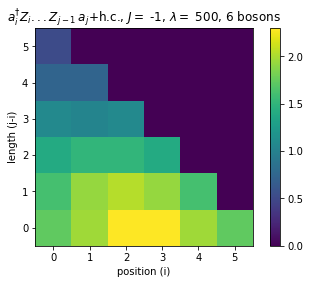

In [7]:
psi0_notgaugefixed = P_sparse.T @ psi0
resRe=np.empty([Nsites,Nsites])
resRe.fill(-1)
resIm=np.empty([Nsites,Nsites])
for l in range(Nsites):
    for i in range(0,Nsites-l):
        hop=[1.0]
        for add in range(i):
            hop.append(l+add)
        hop.append(l)
        hop.append(l+i)
        static=[["z"*i+"|+-",[hop]],["z"*i+"|+-",[hop]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        # correlator = P_sparse@correlator@P_sparse.T.conj()
        H_expt = np.dot(psi0_notgaugefixed.T.conj(),correlator@psi0_notgaugefixed)
        # print(H_expt[0,0],E)
        resRe[l][i]=np.real(H_expt[0,0])
        resIm[l][i]=np.imag(H_expt[0,0])

# from matplotlib import cm
print(resRe.T)
plt.imshow(resRe.T)#,cmap=cm.Reds)#np.flip(resRe,0))
plt.colorbar()
plt.clim(0,resRe.max())
plt.xlabel("position (i)")
plt.ylabel("length (j-i)")
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a^{\dagger}_iZ_i...Z_{j-1}\:a_j$+h.c., $J =$ "+str(hopping_strength)+", $\lambda =$ "+str(field_strength)+", "+str(Nbosons)+" bosons")
plt.show()
# plt.imshow(np.flip(resIm,0))
# plt.colorbar()
# plt.show()

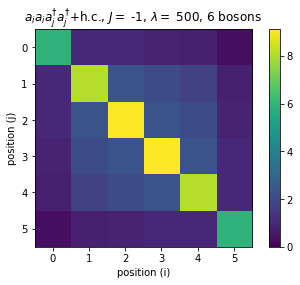

In [8]:
psi0_notgaugefixed = P_sparse.T @ psi0
resRe=np.zeros([Nsites,Nsites])
resIm=np.zeros([Nsites,Nsites])
for i in range(Nsites):
    for j in range(Nsites):
        pairing=[1.0]
        pairing.append(i)
        pairing.append(i)
        pairing.append(j)
        pairing.append(j)
        static=[["|--++",[pairing]],["|++--",[pairing]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        # correlator = P_sparse@correlator@P_sparse.T.conj()
        # H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        H_expt = np.dot(psi0_notgaugefixed.T.conj(),correlator@psi0_notgaugefixed)
        resRe[i][j]=np.real(H_expt[0,0])
        resIm[i][j]=np.imag(H_expt[0,0])

plt.imshow(resRe)
plt.colorbar()
plt.xlabel("position (i)")
plt.ylabel("position (j)")
plt.clim(0,resRe.max())
# plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a_ia_ia^{\dagger}_ja^{\dagger}_j$+h.c., $J =$ "+str(hopping_strength)+", $\lambda =$ "+str(field_strength)+", "+str(Nbosons)+" bosons")
plt.show()

### Build Hamiltonian and calculate ground state

#### Hopping dominates: ground state is (1/2 |2+0> + 1/2 |0+2> + 1/sqrt(2) |1-1>)

In [6]:
hop = [[-10, i, i, i + 1] for i in range(L_modes - 1)]
# hop+=[[-1.0,L_modes-1,L_modes-1,0]]
field = [[0, i] for i in range(L_spin)]
static = [["z|+-", hop], ["z|-+", hop], ["x|", field]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False, check_symm=False, check_herm=False)
H = hamiltonian(static, [], basis=basis, **no_checks)
H_sparse = H.tocsr()
Hgaugefixed = P_sparse @ H_sparse @ P_sparse.T.conj()
E, psi0 = eigsh(Hgaugefixed, k=1, which='SA')
# Relative phases for a two site system
print(np.angle(psi0[0])-np.angle(psi0[1]),np.angle(psi0[2])-np.angle(psi0[1]),np.angle(psi0[0])-np.angle(psi0[2]))
# States with weight
for i in range(len(psi0)):
    print(np.abs(psi0[i]))
# Normalised
# print(abs(psi0.T.conj()@psi0)**2)
# Real?
# np.allclose(P_sparse.T.conj() @ psi0, P_sparse.T @ psi0)

[1.070255e-13] [-3.01980663e-14] [1.37223566e-13]
[0.00015561]
[0.00068683]
[0.00195687]
[0.00407165]
[0.00635391]
[0.0072412]
[0.0053269]
[0.00085647]
[0.00345093]
[0.00879408]
[0.01584639]
[0.02019087]
[0.01627083]
[0.00304285]
[0.01096604]
[0.0242011]
[0.0356065]
[0.03208035]
[0.00789493]
[0.02464047]
[0.04440058]
[0.04619211]
[0.01536308]
[0.03915011]
[0.0498836]
[0.0218327]
[0.03934116]
[0.02002769]
[0.00085647]
[0.00345093]
[0.00879408]
[0.01584639]
[0.02019087]
[0.01627083]
[0.00430323]
[0.01550832]
[0.03422553]
[0.0503552]
[0.04536847]
[0.01367443]
[0.04267854]
[0.07690407]
[0.08000709]
[0.03072616]
[0.07830023]
[0.09976721]
[0.04881939]
[0.08796951]
[0.04905762]
[0.00304285]
[0.01096604]
[0.0242011]
[0.0356065]
[0.03208035]
[0.01367443]
[0.04267854]
[0.07690407]
[0.08000709]
[0.0376317]
[0.0958978]
[0.12218938]
[0.06904105]
[0.12440767]
[0.07756692]
[0.00789493]
[0.02464047]
[0.04440058]
[0.04619211]
[0.03072616]
[0.07830023]
[0.09976721]
[0.06904105]
[0.12440767]
[0.08956656]

In [608]:
psi0_notgaugefixed = P_sparse.T @ psi0
for i in range(Nbosons):
    obs_args={"basis":basis,"check_herm":False,"check_symm":False}
    n=hamiltonian([["|n", [[1.0,i]] ]],[],dtype=np.float64,**obs_args)
    Obs_t = obs_vs_time(psi0_notgaugefixed,t,{"n":n})
    O_n = Obs_t["n"]
    print(i, " ", np.real(O_n))

/tmp/ipykernel_24753/2477622136.py:4: UserWarning: Test for particle conservation not implemented for <class 'quspin.basis.tensor.tensor_basis'>, to turn off this warning set check_pcon=False in hamiltonian
  n=hamiltonian([["|n", [[1.0,i]] ]],[],dtype=np.float64,**obs_args)


0   [0.32272303]
1   [1.04787509]
2   [1.62940189]
3   [1.62940189]
4   [1.04787509]
5   [0.32272303]


In [609]:
for i in range(Nbosons):
    n = [[1.0,i]] #second index chooses which spin or mode to check (ie. 0 is the 1st mode, 1 is the second and same for spins)
    static=[["|n",n]] #z| checks magnetization of spins, |n checks boson number in modes
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    n_check = hamiltonian(static,[],basis=basis,**no_checks)
    n_sparse = n_check.tocsr()
    n_gf = P_sparse@n_sparse@P_sparse.T.conj()
    O_n = np.dot(psi0.conj().T,n_gf.dot(psi0))
    print(O_n)
    n = [[1.0,i,i]]
    static=[["|nn",n]]
    n_check = hamiltonian(static,[],basis=basis,**no_checks)
    n_sparse = n_check.tocsr()
    n_gf = P_sparse@n_sparse@P_sparse.T.conj()
    O_n2 = np.dot(psi0.conj().T,n_gf.dot(psi0))
    print(O_n2)
    print(i, " ", 1+(2*np.abs(O_n))+(np.abs(O_n2)))

[[0.32272303+0.j]]
[[0.40951482+0.j]]
0   [[2.05496087]]
[[1.04787509-1.11022302e-16j]]
[[1.96291025+0.j]]
1   [[5.05866042]]
[[1.62940189+0.j]]
[[3.84186064+0.j]]
2   [[8.10066442]]
[[1.62940189+0.j]]
[[3.84186064+0.j]]
3   [[8.10066442]]
[[1.04787509+0.j]]
[[1.96291025+0.j]]
4   [[5.05866042]]
[[0.32272303+0.j]]
[[0.40951482+0.j]]
5   [[2.05496087]]


[[ 0.64544605  2.09575017  3.25880377  3.25880377  2.09575017  0.64544605]
 [ 1.1630536   2.61335772  3.25880377  2.61335772  1.1630536  -1.        ]
 [ 1.45030412  2.61335772  2.61335772  1.45030412 -1.         -1.        ]
 [ 1.45030412  2.09575017  1.45030412 -1.         -1.         -1.        ]
 [ 1.1630536   1.1630536  -1.         -1.         -1.         -1.        ]
 [ 0.64544605 -1.         -1.         -1.         -1.         -1.        ]]


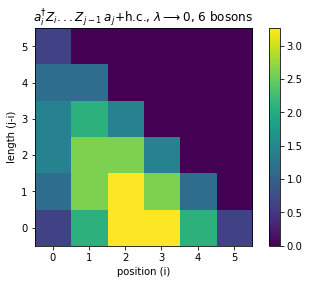

In [13]:
psi0_notgaugefixed = P_sparse.T @ psi0
resRe=np.empty([Nsites,Nsites])
resRe.fill(-1)
resIm=np.empty([Nsites,Nsites])
for l in range(Nsites):
    for i in range(0,Nsites-l):
        hop=[1.0]
        for add in range(i):
            hop.append(l+add)
        hop.append(l)
        hop.append(l+i)
        static=[["z"*i+"|+-",[hop]],["z"*i+"|+-",[hop]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        # correlator = P_sparse@correlator@P_sparse.T.conj()
        H_expt = np.dot(psi0_notgaugefixed.T.conj(),correlator@psi0_notgaugefixed)
        # print(H_expt[0,0],E)
        resRe[l][i]=np.real(H_expt[0,0])
        resIm[l][i]=np.imag(H_expt[0,0])

# from matplotlib import cm
print(resRe.T)
plt.imshow(resRe.T)#,cmap=cm.Reds)#np.flip(resRe,0))
plt.colorbar()
plt.clim(0,resRe.max())
plt.xlabel("position (i)")
plt.ylabel("length (j-i)")
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a^{\dagger}_iZ_i...Z_{j-1}\:a_j$+h.c., $\lambda \longrightarrow 0$, "+str(Nbosons)+" bosons")
plt.show()
# plt.imshow(np.flip(resIm,0))
# plt.colorbar()
# plt.show()

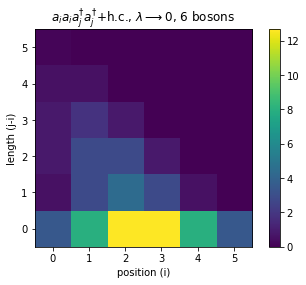

In [14]:
psi0_notgaugefixed = P_sparse.T @ psi0
resRe=np.empty([Nsites,Nsites])
resRe.fill(-1)
resIm=np.empty([Nsites,Nsites])
for i in range(Nsites):
    for l in range(Nsites-i):
        pairing=[1.0]
        pairing.append(i)
        pairing.append(i)
        pairing.append(i+l)
        pairing.append(i+l)
        static=[["|--++",[pairing]],["|++--",[pairing]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        # correlator = P_sparse@correlator@P_sparse.T.conj()
        # H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        H_expt = np.dot(psi0_notgaugefixed.T.conj(),correlator@psi0_notgaugefixed)
        resRe[l][i]=np.real(H_expt[0,0])
        resIm[l][i]=np.imag(H_expt[0,0])

plt.imshow(resRe)
plt.colorbar()
plt.xlabel("position (i)")
plt.ylabel("length (j-i)")
plt.clim(0,resRe.max())
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a_ia_ia^{\dagger}_ja^{\dagger}_j$+h.c., $\lambda \longrightarrow 0$, "+str(Nbosons)+" bosons")
plt.show()

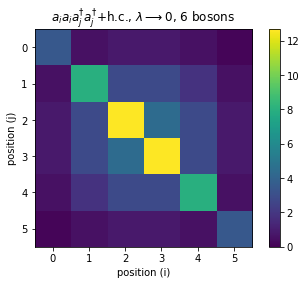

In [15]:
psi0_notgaugefixed = P_sparse.T @ psi0
resRe=np.zeros([Nsites,Nsites])
resIm=np.zeros([Nsites,Nsites])
for i in range(Nsites):
    for j in range(Nsites):
        pairing=[1.0]
        pairing.append(i)
        pairing.append(i)
        pairing.append(j)
        pairing.append(j)
        static=[["|--++",[pairing]],["|++--",[pairing]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        # correlator = P_sparse@correlator@P_sparse.T.conj()
        # H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        H_expt = np.dot(psi0_notgaugefixed.T.conj(),correlator@psi0_notgaugefixed)
        resRe[i][j]=np.real(H_expt[0,0])
        resIm[i][j]=np.imag(H_expt[0,0])

plt.imshow(resRe)
plt.colorbar()
plt.xlabel("position (i)")
plt.ylabel("position (j)")
plt.clim(0,resRe.max())
# plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a_ia_ia^{\dagger}_ja^{\dagger}_j$+h.c., $\lambda \longrightarrow 0$, "+str(Nbosons)+" bosons")
plt.show()

#### Positive field dominates so |-> lowers the energy the most: ground state is |1-1>

In [52]:
hop = [[-1, i, i, i + 1] for i in range(L_modes - 1)]
# hop+=[[-1.0,L_modes-1,L_modes-1,0]]
field = [[0, i] for i in range(L_spin)]
static = [["z|+-", hop], ["z|-+", hop], ["x|", field]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False, check_symm=False, check_herm=False)
H = hamiltonian(static, [], basis=basis, **no_checks)
H_sparse = H.tocsr()
Hgaugefixed = P_sparse @ H_sparse @ P_sparse.T.conj()
E, psi0 = eigsh(Hgaugefixed, k=1, which='SA')
print(np.angle(psi0[0])-np.angle(psi0[1]),np.angle(psi0[2])-np.angle(psi0[1]),np.angle(psi0[0])-np.angle(psi0[2]))
print(np.abs(psi0[0]),np.abs(psi0[1]),np.abs(psi0[2]))

[1.55431223e-15] [-2.22044605e-16] [1.77635684e-15]
[0.0190983] [0.0618034] [0.12247449]


In [53]:
E, psi0 = eigsh(Hgaugefixed, k=20, which='SA')
print(np.sort(E))
print(E[1]-E[0])
# print(psi0)
# psi0[:,6]

[-6.47213595e+00 -5.47213595e+00 -4.47213595e+00 -4.23606798e+00
 -3.47213595e+00 -3.23606798e+00 -3.23606798e+00 -2.47213595e+00
 -2.23606798e+00 -2.23606798e+00 -2.00000000e+00 -1.23606798e+00
 -1.23606798e+00 -1.00000000e+00 -1.00000000e+00 -2.36067977e-01
  2.81270481e-32  6.19832886e-20  5.29243962e-17  2.36067977e-01]
1.0000000000000027


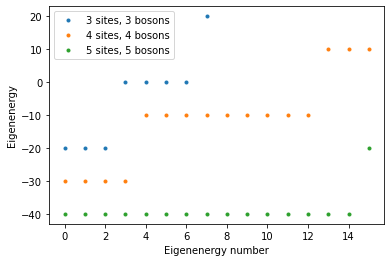

In [64]:
lab.append(str(Nsites)+" sites, "+str(Nbosons)+" bosons")
elist.append(np.sort(E))
for i in range(len(lab)):
    plt.plot(range(len(elist[i])),elist[i],".",label=lab[i])
plt.xlabel("Eigenenergy number")
plt.ylabel("Eigenenergy")
plt.legend()
plt.show()

In [37]:
for i in range(Nbosons):
    n = [[1.0,i]] #second index chooses which spin or mode to check (ie. 0 is the 1st mode, 1 is the second and same for spins)
    static=[["|n",n]] #z| checks magnetization of spins, |n checks boson number in modes
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    n_check = hamiltonian(static,[],basis=basis,**no_checks)
    n_sparse = n_check.tocsr()
    n_gf = P_sparse@n_sparse@P_sparse.T.conj()
    O_n = np.dot(psi0[:,6].conj().T,n_gf.dot(psi0[:,6]))
    print(i, " ", np.real(O_n))

0   0.06250705108631065
1   1.3749952811766661
2   1.5624976677370233


In [593]:
for i in range(Nbosons):
    n = [[1.0,i]] #second index chooses which spin or mode to check (ie. 0 is the 1st mode, 1 is the second and same for spins)
    static=[["|n",n]] #z| checks magnetization of spins, |n checks boson number in modes
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    n_check = hamiltonian(static,[],basis=basis,**no_checks)
    n_sparse = n_check.tocsr()
    n_gf = P_sparse@n_sparse@P_sparse.T.conj()
    O_n = np.dot(psi0.conj().T,n_gf.dot(psi0))
    print(i, " ", np.real(O_n))

0   [[1.]]
1   [[1.]]


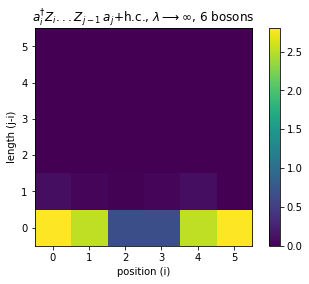

In [10]:
psi0_notgaugefixed = P_sparse.T @ psi0
resRe=np.empty([Nsites,Nsites])
resRe.fill(-1)
resIm=np.empty([Nsites,Nsites])
for l in range(Nsites):
    for i in range(0,Nsites-l):
        hop=[1.0]
        for add in range(i):
            hop.append(l+add)
        hop.append(l)
        hop.append(l+i)
        static=[["z"*i+"|+-",[hop]],["z"*i+"|+-",[hop]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        # correlator = P_sparse@correlator@P_sparse.T.conj()
        # H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        H_expt = np.dot(psi0_notgaugefixed.T.conj(),correlator@psi0_notgaugefixed)
        # print(H_expt[0,0],E)
        resRe[l][i]=np.real(H_expt[0,0])
        resIm[l][i]=np.imag(H_expt[0,0])

plt.imshow(resRe.T)#np.flip(resRe,0))
plt.colorbar()
plt.clim(0,resRe.max())
plt.xlabel("position (i)")
plt.ylabel("length (j-i)")
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a^{\dagger}_iZ_i...Z_{j-1}\:a_j$+h.c., $\lambda \longrightarrow \infty$, "+str(Nbosons)+" bosons")
plt.show()
# plt.imshow(np.flip(resIm,0))
# plt.colorbar()
# plt.show()

In [2]:
psi0_notgaugefixed = P_sparse.T @ psi0
resRe=np.empty([Nsites,Nsites])
resRe.fill(-1)
resIm=np.empty([Nsites,Nsites])
for i in range(Nsites):
    for l in range(Nsites-i):
        pairing=[1.0]
        pairing.append(i)
        pairing.append(i)
        pairing.append(i+l)
        pairing.append(i+l)
        static=[["|--++",[pairing]],["|++--",[pairing]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        # correlator = P_sparse@correlator@P_sparse.T.conj()
        # H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        H_expt = np.dot(psi0_notgaugefixed.T.conj(),correlator@psi0_notgaugefixed)
        resRe[l][i]=np.real(H_expt[0,0])
        resIm[l][i]=np.imag(H_expt[0,0])

plt.imshow(resRe)
plt.colorbar()
plt.xlabel("position (i)")
plt.ylabel("length (j-i)")
plt.clim(0,resRe.max())
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a_ia_ia^{\dagger}_ja^{\dagger}_j$+h.c., $\lambda \longrightarrow \infty$, "+str(Nbosons)+" bosons")
plt.show()

NameError: name 'P_sparse' is not defined

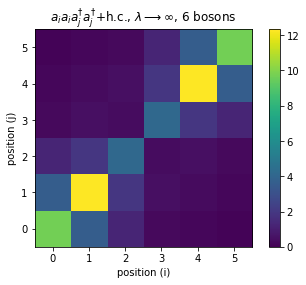

In [11]:
psi0_notgaugefixed = P_sparse.T @ psi0
resRe=np.zeros([Nsites,Nsites])
resIm=np.zeros([Nsites,Nsites])
for i in range(Nsites):
    for j in range(Nsites):
        pairing=[1.0]
        pairing.append(i)
        pairing.append(i)
        pairing.append(j)
        pairing.append(j)
        static=[["|--++",[pairing]],["|++--",[pairing]]]
        no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
        correlator = hamiltonian(static,[],basis=basis,**no_checks).tocsr()
        # correlator = P_sparse@correlator@P_sparse.T.conj()
        # H_expt = np.dot(psi0.T.conj(),correlator@psi0)
        H_expt = np.dot(psi0_notgaugefixed.T.conj(),correlator@psi0_notgaugefixed)
        resRe[i][j]=np.real(H_expt[0,0])
        resIm[i][j]=np.imag(H_expt[0,0])

plt.imshow(resRe)
plt.colorbar()
plt.xlabel("position (i)")
plt.ylabel("position (j)")
plt.clim(0,resRe.max())
plt.axis([-0.5, Nbosons-0.5, -0.5, Nbosons-0.5])
plt.title("$a_ia_ia^{\dagger}_ja^{\dagger}_j$+h.c., $\lambda \longrightarrow \infty$, "+str(Nbosons)+" bosons")
plt.show()

# Energy gap

In [84]:
set=[]
lab = []

In [60]:
###### parameters
min = -1
max = 0
numberofvalues = 50
vals=np.linspace(min,max,numberofvalues)

# Different system sizes and number of bosons - choose number of bosons to be equal to the system size

gj=1
deltas=np.zeros((2,len(vals)))
energy0=np.zeros((2,len(vals)))
energy1=np.zeros((2,len(vals)))
for i in range(len(vals)):
    val=vals[i]
    ##### create model
    hop=[[-0.1,i,i,i+1] for i in range(L_modes-1)]
    # density = [[0,i,i] for i in range(L_modes)]
    field = [[val,i] for i in range(L_spin)]
    static=[["z|+-",hop],["z|-+",hop],["x|",field]]#,["|nn",density]]
    ###### setting up operators
    # set up hamiltonian dictionary and observable (imbalance I)
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    H = hamiltonian(static,[],basis=basis,**no_checks)
    H_sparse = H.tocsr()

    Hgaugefixed=P_sparse@H_sparse@P_sparse.T.conj()
    print("done ")
    E,V = eigsh(Hgaugefixed,k=2,which='SA')
    delta=np.abs(E[1]-E[0])
    if val==0:
        print("E[0] ",E[0]," E[1] ",E[1]," delta ",delta)
    deltas[0][i]=np.abs(val)
    deltas[1][i]=np.abs(delta)

    energy0[0][i]=np.abs(val)
    energy0[1][i]=E[0]

    energy1[0][i]=np.abs(val)
    energy1[1][i]=E[1]

set.append(deltas)

done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
E[0]  -0.647213595499958  E[1]  -0.5472135954999592  delta  0.09999999999999887


In [85]:
lab.append(str(Nsites)+" sites, "+str(Nbosons)+" bosons")

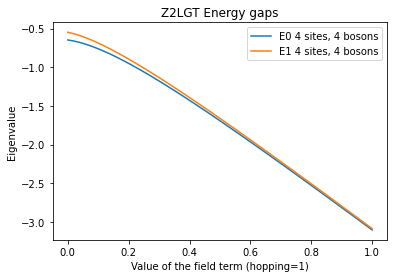

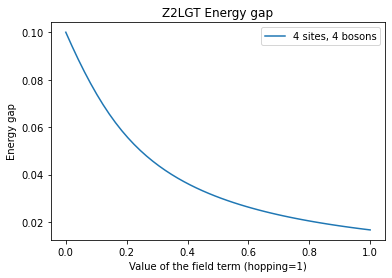

In [64]:
xlabelplot = "Value of the field term (hopping=1)"
plt.title("Z2LGT Energy gaps")
for i in range(len(set)):
    plt.plot(energy0[0],energy0[1],label="E0 "+lab[i])
for i in range(len(set)):
    plt.plot(energy1[0],energy1[1],label="E1 "+lab[i])
plt.xlabel(xlabelplot)
plt.ylabel("Eigenvalue")
plt.legend()
plt.show()

plt.title("Z2LGT Energy gap")
for i in range(len(set)):
    plt.plot(set[i][0],set[i][1],label=lab[i])
    # plt.plot(set[i][0],set[i][0]**(-1),".",label="$x^{-2}$")
plt.xlabel(xlabelplot)
plt.ylabel("Energy gap")
# plt.yscale("log")
# plt.xscale("log")
plt.legend()
plt.show()

#### field fixed varying hopping - scaling of energy gap

In [123]:
set=[]
lab = []
lab.append(str(Nsites)+" sites, "+str(Nbosons)+" bosons")

###### parameters
min = -5
max = 0
numberofvalues = 100
vals=np.linspace(min,max,numberofvalues)
vals=np.logspace(-2,2,numberofvalues)

# Different system sizes and number of bosons - choose number of bosons to be equal to the system size

gj=1
deltas=np.zeros((2,len(vals)))
energy0=np.zeros((2,len(vals)))
energy1=np.zeros((2,len(vals)))
for i in range(len(vals)):
    val=vals[i]
    ##### create model
    hop=[[val,i,i,i+1] for i in range(L_modes-1)]
    # density = [[0,i,i] for i in range(L_modes)]
    field = [[-1,i] for i in range(L_spin)]
    static=[["z|+-",hop],["z|-+",hop],["x|",field]]#,["|nn",density]]
    ###### setting up operators
    # set up hamiltonian dictionary and observable (imbalance I)
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    H = hamiltonian(static,[],basis=basis,**no_checks)
    H_sparse = H.tocsr()

    Hgaugefixed=P_sparse@H_sparse@P_sparse.T.conj()
    print("done ")
    E,V = eigsh(Hgaugefixed,k=2,which='SA')
    delta=np.abs(E[1]-E[0])
    if val==0:
        print("E[0] ",E[0]," E[1] ",E[1]," delta ",delta)
    deltas[0][i]=val
    deltas[1][i]=delta

    energy0[0][i]=val
    energy0[1][i]=E[0]

    energy1[0][i]=val
    energy1[1][i]=E[1]

set.append(deltas)

done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 
done 


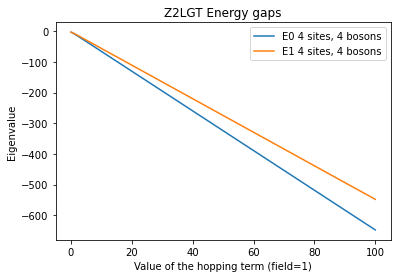

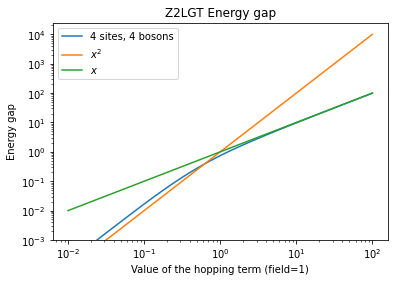

In [126]:
xlabelplot = "Value of the hopping term (field=1)"
plt.title("Z2LGT Energy gaps")
for i in range(len(set)):
    plt.plot(energy0[0],energy0[1],label="E0 "+lab[i])
for i in range(len(set)):
    plt.plot(energy1[0],energy1[1],label="E1 "+lab[i])
plt.xlabel(xlabelplot)
plt.ylabel("Eigenvalue")
plt.legend()
plt.show()

plt.title("Z2LGT Energy gap")
for i in range(len(set)):
    plt.plot(np.abs(set[i][0]),np.abs(set[i][1]),label=lab[i])
    plt.plot(np.abs(set[i][0]),np.abs(set[i][0]**(2)),label="$x^{2}$")
    plt.plot(np.abs(set[i][0]),np.abs(set[i][0]**(1)),label="$x$")
plt.xlabel(xlabelplot)
plt.ylabel("Energy gap")
plt.yscale("log")
plt.xscale("log")
plt.ylim(10**(-3))

plt.legend()
plt.show()

### define initial state (ground state of X field)

In [6]:
##### create model
field = [[-h,i] for i in range(L_spin)]
# density = [[0.01,i,i] for i in range(L_modes)]
static=[["x|",field]]#,["|nn",density]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H1 = hamiltonian(static,[],basis=basis,**no_checks)

H = hamiltonian(static, [], basis=basis, **no_checks)
H_sparse = H.tocsr()
Hgaugefixed = P_sparse @ H_sparse @ P_sparse.T.conj()
_,psi = eigsh(Hgaugefixed,k=1, which='SA')
# P=P_gaugefixed.full()
# psi=np.dot(P.T.conj(),psi)

### Create |0+2> by hand and check where it is in the basis

In [553]:
##### define initial state #####
psispin = (1 / np.sqrt(2)) * np.array([1, 1])
#Boson - find index of Fock state |20>
iboson = basis_boson.index("02")
# Ns is the size of the Hilbert space
psiboson = np.zeros(basis_boson.Ns, dtype=np.float64)
psiboson[iboson] = 1.0
psi = np.kron(psispin, psiboson)
print(psi)

[0.         0.         0.         0.         0.         0.
 0.70710678 0.         0.         0.         0.         0.
 0.         0.         0.         0.70710678 0.         0.        ]


In [555]:
# Check the state which was made
statetest = [[1.0,0]]  #second index chooses which spin or mode to check (ie. 0 is the 1st mode, 1 is the second and same for spins)
static = [["|n", statetest]]  #z| checks magnetization of spins, |n checks boson number in modes
no_checks = dict(check_pcon=False, check_symm=False, check_herm=False)
H_check = hamiltonian(static, [], basis=basis, **no_checks)
print(np.dot(psi.conj().T, H_check.dot(psi)))

0j
